In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.utils as vutils
import matplotlib.pyplot as plt
import numpy as np


In [4]:
# Hyperparameters
batch_size = 128
image_size = 32
latent_dim = 100
num_epochs = 50
learning_rate = 0.0002
beta1 = 0.5


In [5]:
# Data transformations
transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

# Load dataset
dataset = datasets.CIFAR10(root='./data', download=True, transform=transform)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)


100%|██████████| 170498071/170498071 [00:01<00:00, 90840705.16it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data


In [6]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.ConvTranspose2d(latent_dim, 512, kernel_size=4, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 3, kernel_size=4, stride=2, padding=1, bias=False),
            nn.Tanh()
        )

    def forward(self, x):
        return self.model(x)


In [7]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3, 128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x).view(-1, 1)


In [8]:
# Initialize models
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
generator = Generator().to(device)
discriminator = Discriminator().to(device)

# Optimizers
optimizer_g = optim.Adam(generator.parameters(), lr=learning_rate, betas=(beta1, 0.999))
optimizer_d = optim.Adam(discriminator.parameters(), lr=learning_rate, betas=(beta1, 0.999))

# Loss function
criterion = nn.BCELoss()


In [9]:
for epoch in range(num_epochs):
    for i, (real_images, _) in enumerate(dataloader):
        # Move data to device
        real_images = real_images.to(device)
        batch_size = real_images.size(0)

        # Labels for real and fake images
        real_labels = torch.ones(batch_size, 1).to(device)
        fake_labels = torch.zeros(batch_size, 1).to(device)

        ### Train Discriminator ###
        optimizer_d.zero_grad()

        # Real images
        outputs = discriminator(real_images)
        loss_real = criterion(outputs, real_labels)
        loss_real.backward()

        # Fake images
        z = torch.randn(batch_size, latent_dim, 1, 1).to(device)
        fake_images = generator(z)
        outputs = discriminator(fake_images.detach())
        loss_fake = criterion(outputs, fake_labels)
        loss_fake.backward()

        optimizer_d.step()
        d_loss = loss_real + loss_fake

        ### Train Generator ###
        optimizer_g.zero_grad()

        # Generate fake images and compute loss
        outputs = discriminator(fake_images)
        g_loss = criterion(outputs, real_labels)  # Try to make discriminator classify fakes as real
        g_loss.backward()

        optimizer_g.step()

        if i % 100 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(dataloader)}], "
                  f"D Loss: {d_loss.item():.4f}, G Loss: {g_loss.item():.4f}")


Epoch [1/50], Step [1/391], D Loss: 1.5193, G Loss: 3.4466
Epoch [1/50], Step [101/391], D Loss: 0.2004, G Loss: 14.7714
Epoch [1/50], Step [201/391], D Loss: 0.4060, G Loss: 3.5359
Epoch [1/50], Step [301/391], D Loss: 0.8971, G Loss: 2.0576
Epoch [2/50], Step [1/391], D Loss: 0.9384, G Loss: 4.2875
Epoch [2/50], Step [101/391], D Loss: 0.9465, G Loss: 5.1728
Epoch [2/50], Step [201/391], D Loss: 0.7476, G Loss: 2.3869
Epoch [2/50], Step [301/391], D Loss: 0.6103, G Loss: 3.8696
Epoch [3/50], Step [1/391], D Loss: 0.9048, G Loss: 1.3910
Epoch [3/50], Step [101/391], D Loss: 0.9983, G Loss: 1.8266
Epoch [3/50], Step [201/391], D Loss: 0.5822, G Loss: 2.5590
Epoch [3/50], Step [301/391], D Loss: 1.2756, G Loss: 6.8776
Epoch [4/50], Step [1/391], D Loss: 0.8226, G Loss: 3.8393
Epoch [4/50], Step [101/391], D Loss: 0.4478, G Loss: 3.1470
Epoch [4/50], Step [201/391], D Loss: 0.5007, G Loss: 3.3840
Epoch [4/50], Step [301/391], D Loss: 0.8932, G Loss: 3.8388
Epoch [5/50], Step [1/391], D L

In [12]:
# Save the generator and discriminator models
torch.save(generator.state_dict(), 'generator_cifar.pth')
torch.save(discriminator.state_dict(), 'discriminator_cifar.pth')

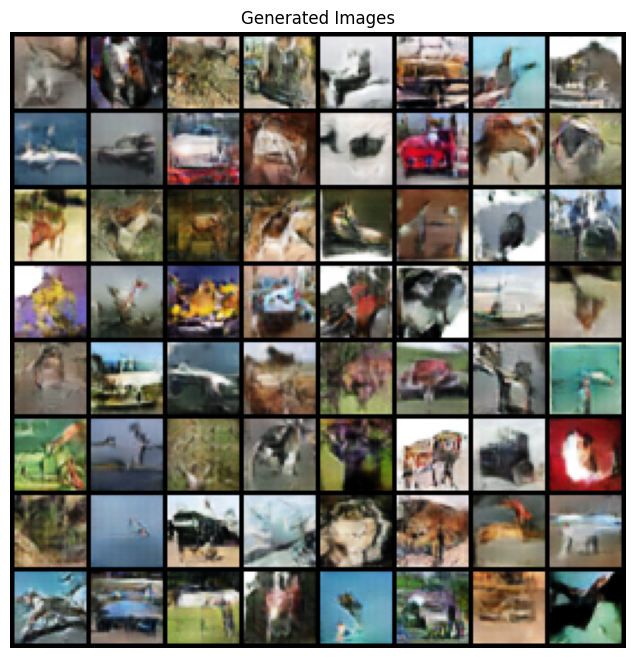

In [10]:
# Generate a batch of fake images
with torch.no_grad():
    fake_images = generator(torch.randn(64, latent_dim, 1, 1).to(device)).detach().cpu()
    fake_images = (fake_images + 1) / 2  # Rescale images to [0, 1] for visualization

# Display generated images
plt.figure(figsize=(8, 8))
plt.axis("off")
plt.title("Generated Images")
plt.imshow(np.transpose(vutils.make_grid(fake_images, padding=2, normalize=True), (1, 2, 0)))
plt.show()


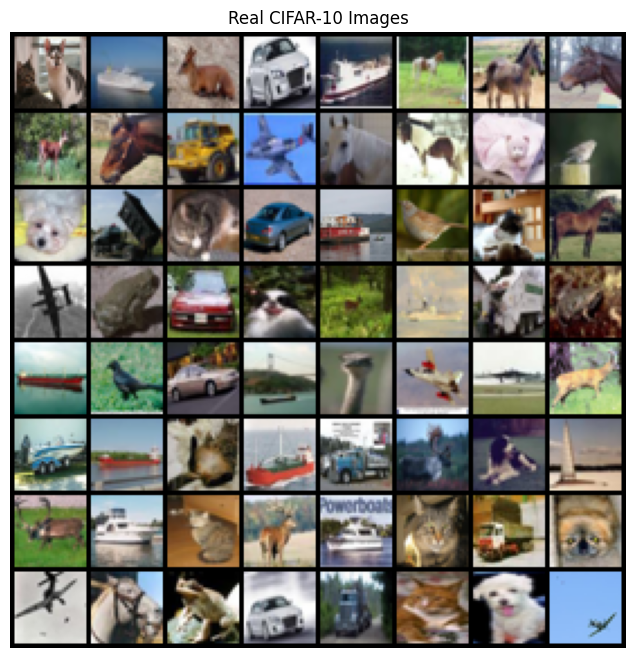

In [11]:
# Get a batch of real images
real_batch = next(iter(dataloader))
real_images = (real_batch[0] + 1) / 2  # Rescale to [0, 1]

# Display real images
plt.figure(figsize=(8, 8))
plt.axis("off")
plt.title("Real CIFAR-10 Images")
plt.imshow(np.transpose(vutils.make_grid(real_images[:64], padding=2, normalize=True), (1, 2, 0)))
plt.show()
